# Variability of test error

Theoretical background is covered in the following notebooks:
* [point-estimators.ipynb](./point-estimators.ipynb) 
* [clt_approximation.ipynb](./clt_approximation.ipynb)

In [1]:
import numpy as np
import numpy.random as random
import pandas as pd

from pandas import Series
from pandas import DataFrame
from typing import List

from sklearn.linear_model import LogisticRegression

from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Train two classifiers on relatively large dataset 

We consider here a relatively simple prediction task where the target function is nearly deterministic and the feature space is relatively small.

In [2]:
sampler = lambda n: data_sampler(n, 8, lambda x: logit(x, Series([10, 10])))

In [3]:
train = sampler(10000)
features = list(train.columns.values[:-1])
clf_1 = MajorityVoting(features)
clf_1.fit(train, train['y'])
clf_2 = LogisticRegression(solver = 'lbfgs')
clf_2.fit(train[features], train['y'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## II. Measuring test error on different dataset sizes

### Empirical risk aka test error

In [4]:
def empirical_risk(clf, X: DataFrame, y: Series) -> float:
    return sum(clf.predict(X) != y) / len(X) * 100

In [5]:
test = sampler(100)
display(empirical_risk(clf_1, test[features], test['y']))
display(empirical_risk(clf_2, test[features], test['y']))

23.0

26.0

### Configuration and template for data collection

In [6]:
k = 1000
sizes = [1, 10, 100, 1000]

result = (combine_categories({'size': sizes, 'method': ['MV', 'LR'], 'experiment': list(range(k))})
         .assign(test_error = np.nan)
         .set_index(['size', 'method', 'experiment'])
         .sort_index())
head(result)

test_error
size method experiment            
1    LR     0                  NaN
            1                  NaN
            2                  NaN
            3                  NaN
            4                  NaN

### Experiment

In [7]:
from tqdm.notebook import trange, tqdm_notebook

for size in sizes:
    for experiment in trange(k, desc = 'Size: {:_>4}'.format(size)):
        test = sampler(size)
        result.loc[(size, 'MV', experiment), 'test_error'] = empirical_risk(clf_1, test[features], test['y'])
        result.loc[(size, 'LR', experiment), 'test_error'] = empirical_risk(clf_2, test[features], test['y'])
tail(result.sort_index().unstack('method'))        

test_error      
method                  LR    MV
size experiment                 
1000 995              24.2  24.3
     996              23.4  24.6
     997              24.3  25.2
     998              24.6  25.1
     999              26.1  26.2

### Visualisation

In [8]:
from pandas.api.types import CategoricalDtype
SizeType = CategoricalDtype(sizes, ordered = True)
df = result.reset_index().assign(size = lambda df: df['size'].astype(SizeType))
df.to_csv('results/test_errors.csv', index = False)
head(df)

,size,method,experiment,test_error
0,1,LR,0,0.0
1,1,LR,1,0.0
2,1,LR,2,0.0
3,1,LR,3,0.0
4,1,LR,4,0.0


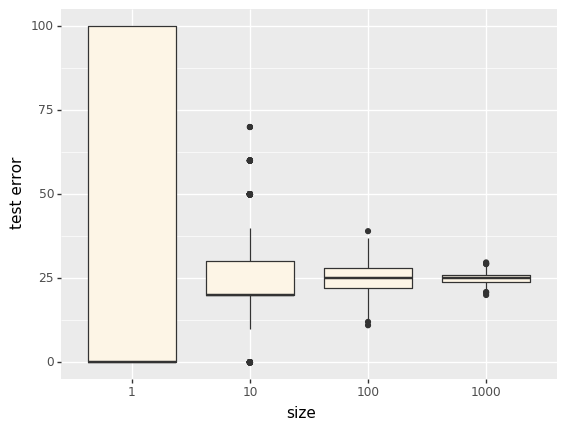

<ggplot: (-9223372029836286909)>

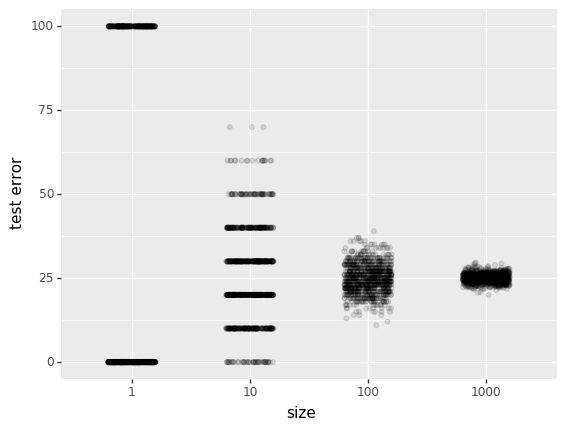

<ggplot: (7018690750)>

In [9]:
p = ggplot(data = df[df['method'] == 'LR'])
p = p + geom_boxplot(aes(x ='size', y = 'test_error'), fill = "oldlace")
p = p + scale_y_continuous(name = "test error")
p.save('test_error_fluctuations_1.pdf', path='results', height=6, width=6, verbose=False)
display(p)
p = ggplot(data = df[df['method'] == 'LR'])
p = p + geom_jitter(aes(x ='size', y = 'test_error'), width =0.2, alpha=0.1)  
p = p + scale_y_continuous(name = "test error")
p.save('test_error_fluctuations_2.pdf', path='results', height=6, width=6, verbose=False)
display(p)

# Homework

## 2.1  Empirical study of convergence speed (<font color='red'>1p</font>)

Let us study empirically whether the empirical risk indeed converges to some value for large enough sample sizes $N$. For that generate 100 datasets for $N = 1,10,50,100,500,1000$ and compute empirical risk estimates for each of them.
From that estimate the value $\varepsilon_N$ such that $$\Pr[|R_N(f)-R(f)|\geq \varepsilon_N] \leq 5\%\enspace.$$

* Draw corresponding boxplots and try to estimate to which value the empirical risk converges.
  Declare this value as $R(f)$.

* Next compute $\Delta=|R_N(f) − R(f)|$ for each dataset size and run and find an empirical $95\%$ quantile $\hat{\varepsilon}_N$ to get the approximate value of $\varepsilon_N$.

* Plot the resulting dependence $\varepsilon_N\sim N$ on log-log scale and interpret results.

**Hint:** You can use `numpy.quantile()` to compute empirical quantiles. 

In [10]:
from numpy import quantile

## 2.2 Theoretical study of convergence speed (<font color='red'>1p</font>)

It is easy to see that it is possible to show that empirical risk $R_N (f)$ is  directly linked to binomial distribution if we consider classification tasks with a standard loss function $L(\hat{y}, y)=[\hat{y}\neq y]$:
\begin{align*}
 N · R_N (f)\sim \texttt{scipy.stats.binom}(n = N, p = R(f)).
\end{align*}
The latter allows us to find $\varepsilon_N$ analytically instead of doing simulation experiments: 

* We need to find $\varepsilon_n$ such that $\Pr[|R_N(f)−R(f)|\geq \varepsilon_N] = 5\%$.
* Since the $R_N(f)$ is just a scaled binomial distribution, we must solve the equation

  \begin{align*}
   \Pr[Y \leq N\cdot(p−\varepsilon_N)]+\Pr[Y \geq N\cdot(p+\varepsilon_N)]=5%
  \end{align*}  
  for a random variable $Y ∼ \texttt{binom}(N, p)$ where $p = R(f)$. 

* As binomial distribution is symmetric, we can simplify $\Pr[Y \leq N\cdot(p−\varepsilon_N)]=2.5\%$ and solve the corrsponding equality with `binom.ppf` to get numerical values of $\varepsilon_N$. 
  Using this information, write a function that analytically computes $\varepsilon_N$. 

Implement the solution outlined above:
* Define a function that computes theoretical estimates $\varepsilon_N$.
* Add these theoretical estimates to the figure done in the previous exercise.
* Tabulate how much samples are needed to get the precision $\varepsilon_N=10, 5, 1, 0.5, 0.1\%$ for true risk values $R(f)=10\%, 50\%, 90\%$.

In [11]:
from scipy.stats import binom

## 2.3 Estimating convergence through moment matching* (<font color='red'>2p</font>) 

For regression tasks the distribution $|R_N(f)-R(f)|$ is unknown for most cases but by the law of large numbers it will converge to a normal distribution. Hence, we can approximate $R_N(f)-R(f)$ with a normal distribution $\texttt{scipy.stats.norm}(loc = R_N, scale=\sigma)$ where $\sigma$ is the standard deviation of $R_N(f)$.
This provides a handle for theoretical estimation of the convergence speed.

* Assume that the quadratic loss $L(\hat{y},y)=(\hat{y}-y)^2$ of an individual prediction follows a squared Laplace distribution `scipy.stats.laplace`.
* Repeat the experiment scheme outlined in Exercise 2.1 to get empirical quantiles for $\hat{\varepsilon}_N$.
* Use moment maching to find `loc` and `scale` parameters for the normal approximation and `normal.ppf` to get  estimates of $\varepsilon_N$.
* Plot a figure containing empirical and theoretical estimates as done in Exercise 2.2. Interpret the results.
* Tabulate how much samples are needed to get the relative precision $\frac{\varepsilon_N}{R(f)}=10, 5, 1, 0.5, 0.1\%$ for different true risk values $R(f)$.

In [12]:
from scipy.stats import norm
from scipy.stats import laplace